# Notebook for understanding PCA 

PCA is generally a dimensionality reduction technique used in exploratory data analysis, vizualisation and data preprocessing. 

PCA works by linearly transforming data onto a new coordinate system such that the directions (principal components) are along the directions of greatest variance. In this way, we can use these principal components to explain our data hopefully in a more compact way than original data, so we can throw away some columns. -> Dimensionality reduction. 

Other applications include
* regression 
* outlier detection 
* noise reduction 
* dimensionality reduction 


In the procedure we "find" our principal components, thus they are created. And we call such componentns **latent variables**. These are as mentioned the directions of greates variance, and describes our data by the following.  
The **coordinates** of the samples (points in X) in terms of the **new principal components** are called the **scores**, T.  
The new components, axies, are linear combinations of the old ones, called **loadings**, P. 

Given this description we can decompose our data matrix as 
$$X = \tilde{X} + E = TP^T + E$$

Since we find several components, up to the same amount of original data variables, we can determine to only retain a subset, and we denote this by a. 
$$X = \tilde{X} + E = T_a P_a^T + E$$

## Mathematics of PCA

By analyzing the correlation matrix of the data we can derive features that matter the most with respect to the variance. 

### Data 
Loading in the wine dataset from sklearn 

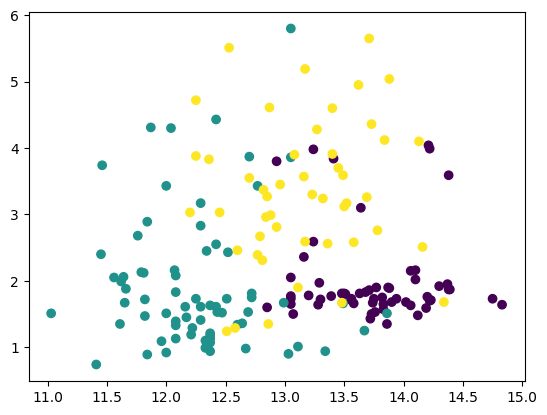

In [170]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
import seaborn as sns

# features, target = load_wine(return_X_y=True)
bunch = load_wine()

X=bunch.data
y=bunch.target
feature_names=bunch.feature_names

plt.scatter(X[:, 0], X[:, 1], c=y)


### Step 1 - Mean centering and Normalization 

This step is crucial for PCA to work. If not taken care of we end up with a significant bias towards the components that have higher variance or are greater in scale. 

Not mean centering may lead to the first principal component equal to the mean of the data. 

From the plot above we see that the different axies are different in scale, but also that the data is not mean centered. We therefore apply normalization. 

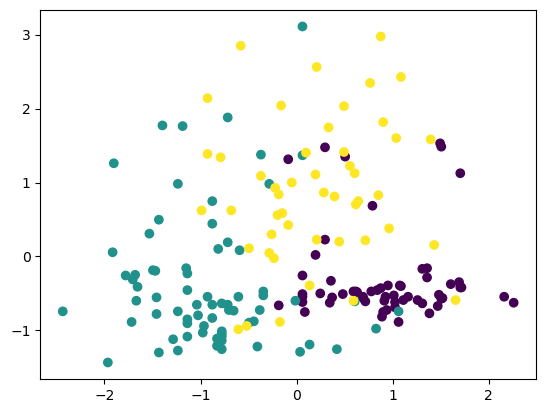

In [171]:
means = np.mean(X, axis=0)
stds = np.std(X, axis=0)

X_norm = (X-means)/(stds)

plt.scatter(X_norm[:, 0], X_norm[:, 1], c=y)

### Step 2 - Eigenvalue Approach 

One might apply SVD to the data matrix directly, however this is computationally heavy if we have a lot more samples than features. In this case we can apply SVD to the covariance matrix $XX^T$ or $X^T X$, whichever is smallest. 

In [172]:
U, S, VT = np.linalg.svd(X_norm, full_matrices=False)

P = VT.T 
T = U@S

U.shape, S.shape, P.shape


((178, 13), (13,), (13, 13))

### Step 3 - Results

Now that we have the scores and loadings we can view our results in this new frame. 

First we can plot a scree-plot. This shows the explained variance by each PC and is given by the singular values from the SVD. The scree plot can plot the singular values directly, however they dont show the perentage explained, thus we can divide by the total variance. 

<BarContainer object of 13 artists>

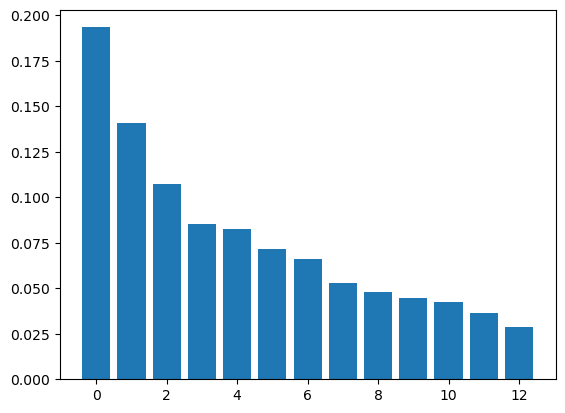

In [173]:
X_transformed = X_norm@P

var_sum = np.sum(S)

plt.bar(x=np.arange(0, 13), height=S/var_sum)


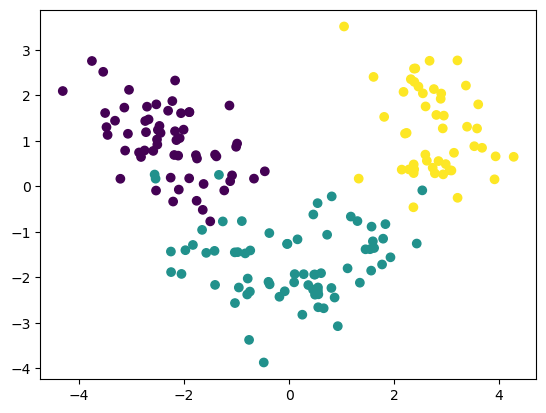

In [174]:
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y)

And as we can see the resulting plot looks much better than the original one, in terms of ability to group samples.  

But what does the PC's tell us? From the scree we can see PC1 explain most of the data variance, around 20%. But what does this consist of? 

In [175]:
import pandas as pd 

pd.DataFrame(P[:, 0].reshape((1, 13)), columns=feature_names)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,-0.144329,0.245188,0.002051,0.23932,-0.141992,-0.394661,-0.422934,0.298533,-0.313429,0.088617,-0.296715,-0.376167,-0.286752


<BarContainer object of 13 artists>

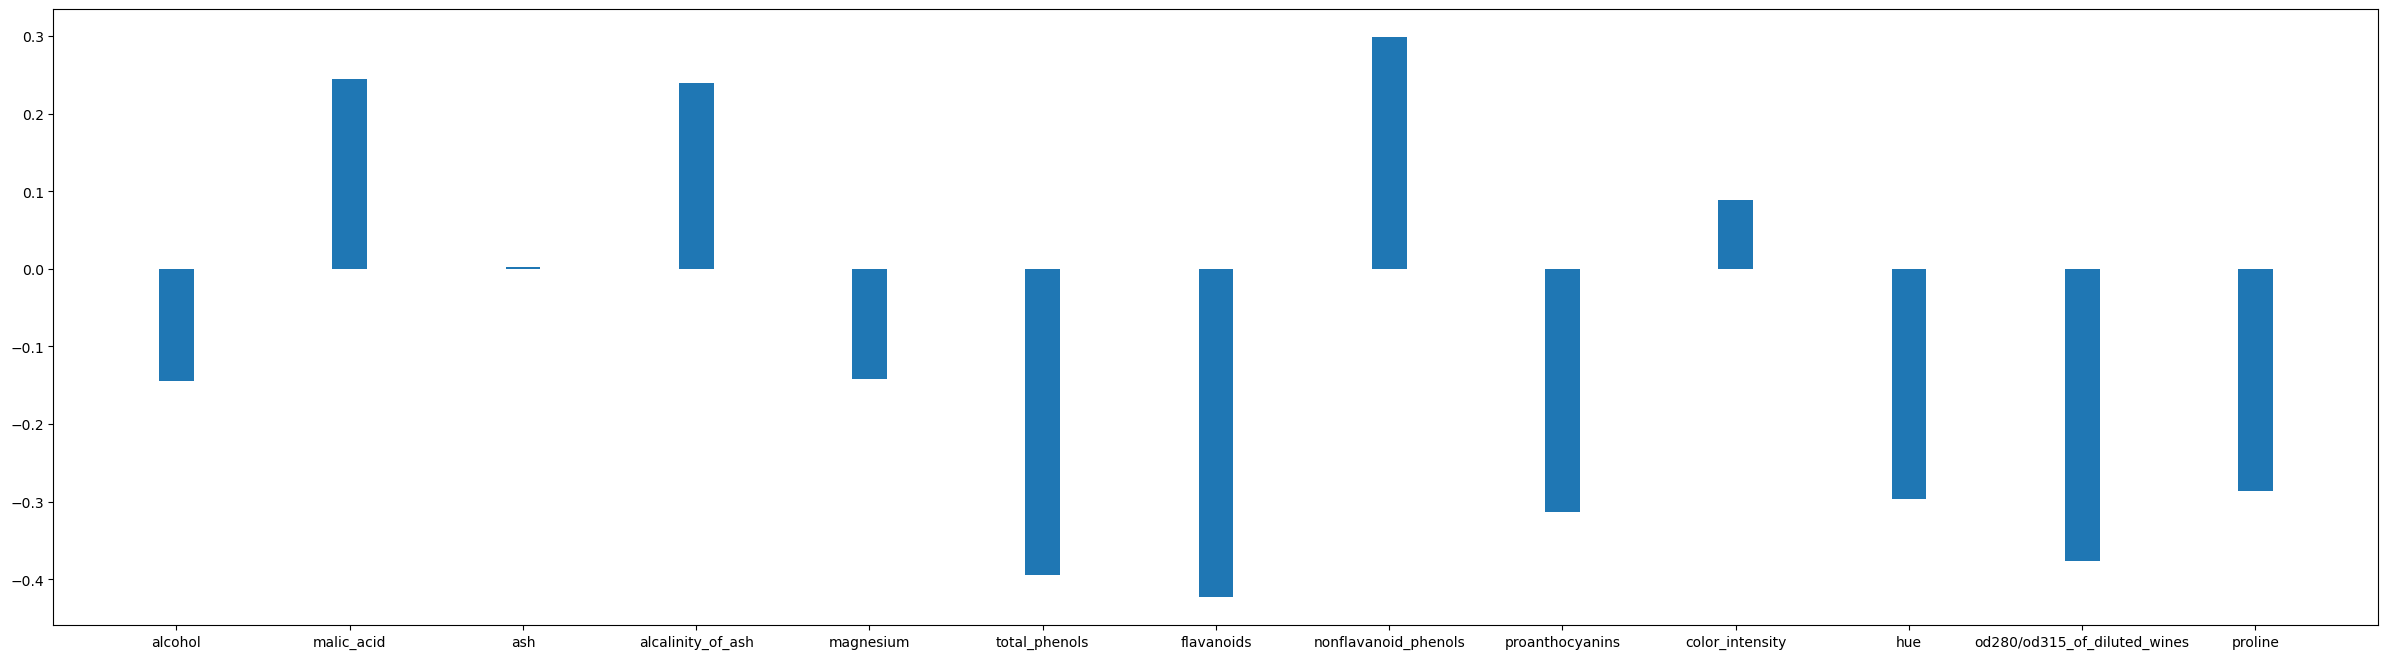

In [176]:
fig = plt.figure(1, [30, 8])

plt.bar(x=feature_names, height=P[:, 0], width=0.2)


So this shows each original feature's contribution to PC1. However it does not give a clear indication of whats important. As in this case, we have several components contribution near equal amounts, and some being positive and negative. 

A more revealing way is correlations loadings plot. 

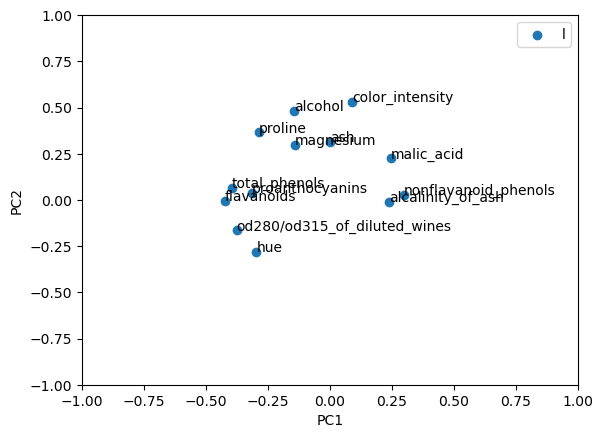

In [179]:
plt.scatter(P[:, 0]/np.linalg.norm(P[:,0]) , P[:, 1]/np.linalg.norm(P[:,1]))


plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.ylabel('PC2')
plt.xlabel('PC1')

for i in range(len(feature_names)): 
    plt.annotate(feature_names[i], (P[i, 0], P[i, 1]))

## NIPALS - Non-linear iterative partial least squares 

This method employs an iterative minimization technique to find the principal components. This involves matrix deflation and minimization. 


In [235]:
def NIPALS(X, n, tol = 0.001):

    X_h = X 
    h = 1 

    T = np.zeros_like(X)
    P = np.zeros((X.shape[1], n))

    for i in range(0, n): 
        t_h = X_h[:, 0]

        prev_t = t_h
        change = tol+1
        running = True
        while running: 
            p_h = ((X_h.T@t_h)/np.linalg.norm((X_h.T@ t_h)))
            t_h = X_h@p_h

            change = np.linalg.norm((prev_t - t_h), 2)

            if (change < tol): 
                running = False
                T[:,i] = t_h
                P[:, i] = p_h
                X_h = X_h - (t_h.reshape(X_h.shape[0],1)) @ (p_h.reshape(X_h.shape[1],  1)).T

            else: 
                prev_t = t_h

    
    return T, P 


In [242]:
T, P = NIPALS(X_norm, 13, tol=0.000001)

In [243]:
X_transformed = X_norm@P

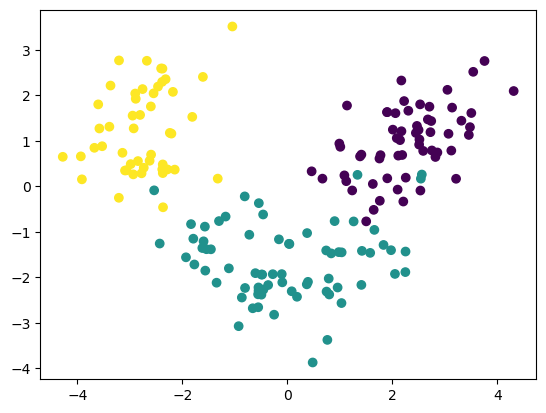

In [244]:
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y)

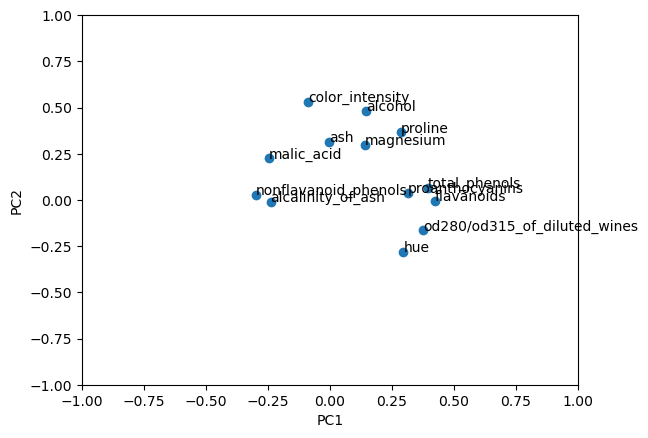

In [245]:
plt.scatter(P[:, 0]/np.linalg.norm(P[:,0]) , P[:, 1]/np.linalg.norm(P[:,1]))


plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.ylabel('PC2')
plt.xlabel('PC1')

for i in range(len(feature_names)): 
    plt.annotate(feature_names[i], (P[i, 0], P[i, 1]))

## Discussion aboud PCA

### Limitations 

In PCA we assume that the variance of the data is close to orthogonal, or able to be modeled by a orthogonal basis. By aligning this basis along these directions we can reduce the number of needed features to "explain" our data, thus enabling dimensionality reduction. However, this fails when variance is not orthogonal and PCA results are less usefull. 

Also, we can use PCA in regression tasks. We then apply PCA to our data and do regression on the data transformed into the new PC space. This introduce advantages, such as orthogonality keeping the explainatory matrix, X, proper, also reducing amount of working data. However there is no guarantee that PC1 is the best component for predicting, even though its explaining the most variance.  
In methods like Partial least squares regression we fix this by not only applying SVD to the X matrix but also Y. We want to capture most of both's variance, but also maximizing the covariance between the two, so prediction is possible. 

### Deciding the number of PC's

As seen in the NIPALS implementation or in the SVD approach, we explain the most variance with the first few PCs. Thus the question arises for when we use enough PCs. If, say, the first 3 components explain 99% of the data, do we need another component? Also, taking noise into account, we assume the latter PCs to be more affected by noise.  

By this we can see, removing PCs works as dimentionality reduction: removing columns that are not contribution enough saving computation time and space. But also, noise reduction if the latter components are mostly noise and we remove them. 

Data can be reprojected back into the original components space (by applying the inverse of loadings), so if we apply PCA, remove the last few noisy components, and transform back, we would have removed some of the noise. 

Deciding number of PCs thus is a task of looking at explained variance and what the latter components consist of. 

One could also apply cross-validation to the decision of #PCs. We vary the number of PCs and project some new data onto them and compute residuals. In this way we can see at what point we make diminishing returns. 

### Outliers 
We can also use PCA to find samples classified as outliers in our data. We usually look at different measures for such points to determine if they are an outlier.
* Leverage; the distance of the sample to the origin of our model. We geometrically think of PCA as a hyperplane spanned by the PCs. Then the leverage of any point is the distance between the origin and the sample. 

* Residual is the distance of the sample to the model. Being the orthogonal distance between the sample and the plane. 

We often combine these in order to make metrics for determining outliers. 
<div>
<img src="./images/PCA_leverageAndResidual.png" width="350">
</div>

**Hotelling's T^2**
This method is statistical applying a multivariate studen-t test. We assign a T^2 score to each sample and based on a hard threshold we determine outliers. 

**Leverage**
Find the leverage of sampels, and given a critical leverage value we can remove points. Also based on thresholds. This threshold is defined as 
$$h_{crit} = 3\frac{A + 1}{m}$$

A is the number of total PCs and m is the number of samples.  
Interestingly there is a linear relationship beteween the two methods. 
$$T^2 = \frac{m-1}{(h-1)/m}$$
where h is the leverage. 

Another way of detecting outliers are more visual or enterpretable. As looking at plots of the data in the two first principal components and seeing if any are far away from the bunch. 

**Confidence ellipse in the score space**
A more rigid visual method is to include a confidence ellipse showing a radius in which all points should lie. However this is by all means not a critical limit.  




## Related PCA methods 

### RPCA - Rotated PCA

RPCA is a method trying to combat the case where the variance is not best explained by orthogonal vectors. Here we rotate the found PCs to better hit the clusters of our data. This, however, reduce the explained variance of the rotated PC, and could ruin the orthogonality of the solution. 